<a href="https://colab.research.google.com/github/abasu644/dataanalysis/blob/master/incident_management/AIOps_Incident_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

### Install and Import

In [1]:
import tensorflow as tf

print("Importing packages")
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Importing packages
Found GPU at: /device:GPU:0


In [2]:
!pip install https://github.com/abasu644/transformers/archive/master.zip
!pip  install pytorch-nlp

     | 4.7MB 16.8MB/s
     |████████████████████████████████| 645kB 5.0MB/s 
     |████████████████████████████████| 1.0MB 51.3MB/s 
     |████████████████████████████████| 860kB 50.8MB/s 
  Created wheel for transformers: filename=transformers-2.1.1-cp36-none-any.whl size=312921 sha256=ea756432ed58333b2faf126ae91f2449b51776bc3059f56a4b7cb83179858966
  Stored in directory: /tmp/pip-ephem-wheel-cache-zsdm8vsd/wheels/84/c1/bb/9eabb2cdf1c1310b2c9b19bc5443784d13476c0dd8f3e54475
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=a63252d459cec7d73a1ebf35d5fd5ca9cc1d18b116fb8c3b1ff95d1ed960e24c
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built transformers sacremoses
     |████████████████████████████████| 92kB 4.4MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification ,BertForNextSentencePrediction
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Load Dataset


Incident Data



In [7]:
!git clone https://github.com/abasu644/dataanalysis.git
!unzip dataanalysis/data/opis_events_Jan2019_Oct2019_incident.zip
filepath="OPIS_incident_data.csv"

Cloning into 'dataanalysis'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.
Archive:  dataanalysis/data/opis_events_Jan2019_Oct2019_incident.zip
  inflating: opis_events_Jan2019_Oct2019/events_2019_01.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_03.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_04.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_05.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_06.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_07.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_08.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_09.csv  
  inflating: opis_events_Jan2019_Oct2019/events_2019_10.csv  
  inflating: OPIS_incident_data.csv  


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Importing Textblob package
from textblob import TextBlob

# Importing CountVectorizer for sparse matrix/ngrams frequencies
from sklearn.feature_extraction.text import CountVectorizer

## Import datetime
import datetime as dt
import nltk.compat
import itertools
import chardet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
with open(filepath,"rb") as mydata:
    result = chardet.detect(mydata.read(1000000))
print(result)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [9]:
pd.set_option('display.max_colwidth', -1)
dfi = pd.read_csv(filepath);
dfi.head(2)

Case ID Environment Case Record Type  ... Open Closed Account Name
0  5002I00001wFRqZ  Production  Incident         ...  1    0      OPIS       
1  5002I00001uW3pn  Production  Service Request  ...  0    1      OPIS       

[2 rows x 18 columns]

In [0]:
dfi = pd.read_csv(filepath);
#df = pd.read_csv("OPIS_incident_data.csv")
dfi=dfi[["Description","Subject"]]
dfi=dfi.drop_duplicates()
df_pos=dfi.copy()

df_neg=dfi.copy()
df_neg.index=np.random.permutation(df_neg.index)
df_neg=df_pos.merge(df_neg, left_index=True,right_index=True) 
df_neg=df_neg[['Description_x','Subject_y']]
df_neg.columns=["Description","Subject"]
df_pos['Next_Sent']=1
df_neg['Next_Sent']=0
dftrain=pd.concat([df_pos,df_neg],axis=0)


In [0]:
# Data preparation
from nltk.corpus import stopwords
from nltk import word_tokenize,sent_tokenize
from textblob import Word
import re
stop = stopwords.words("english")
stop.extend(['Comment','subscriptions','Edit','To','Monitor','manage','Alert','Triggered','EMAIL','EXTERNAL','click'])
def prepare_data_snp(df):
  #Start Pars
  df['sent']=df.apply(lambda s: "CLSTOKEN " + re.sub(r"http\S+", "", s['Subject'] )+ 
                      " SEPTOKEN " + re.sub(r"http\S+", "", s['Description'] )  + " SEPTOKEN ",axis=1 )
  
  df["sent"] = df["sent"].str.replace("[^\w\s]"," ")
  df["sent"] = df["sent"].str.replace("\n"," ")
  df["sent"] = df["sent"].str.replace("\t"," ")
  df["sent"] = df["sent"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  df["sent"] = df["sent"].apply(lambda x: " ".join([Word(myword).lemmatize() for myword in x.split()])  )
  def filterToken(token_txt):
    token_txt=word_tokenize(token_txt)
    finaltokenized=[]
    for token in token_txt:
      def removeSystemtoken(s):
        d=l=u=0
        for c in s:
            if c.isdigit():
                d=d+1
            elif c.isalpha():
                l=l+1
            else:
                u=u+1
        return d,l,u
      digc,letc,uc=removeSystemtoken(token)
      if  digc >1 and letc>0 :
        continue
      elif digc >0 and letc==0 :
        continue 
      elif digc ==0 and letc==0 and uc>0:
        continue
      else:
        finaltokenized.append(token)
    return (' ').join(finaltokenized)
  df["sent"] =  df["sent"].apply(lambda x: filterToken(x))
  df["sent"] = df["sent"].str.replace("CLSTOKEN","[CLS]")
  df["sent"] = df["sent"].str.replace("SEPTOKEN","[SEP]")
  return df.sent.values,df.Next_Sent.values

dt,labels=prepare_data_snp(dftrain.sample(frac=1))


## Inputs

In [0]:
MAX_LEN=128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent)[:MAX_LEN] for sent in dt]

# Convert token to vocabulary indices
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
  
#attention_masks=np.array(attention_masks)  

segment_ids=[]
for idi in input_ids:
  #print(idi.shape)
  first_sent_len= np.where(idi==102)[0][0]
  sec_sent_len= MAX_LEN-(first_sent_len)
  #print(first_sent_len)
  seg_id =first_sent_len*[0] + sec_sent_len*[1]
  segment_ids.append(seg_id)
  


In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
train_seg_masks, validation_seg_masks, _, _ = train_test_split(segment_ids, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
train_seg_masks = torch.tensor(train_seg_masks)
validation_seg_masks = torch.tensor(validation_seg_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size=32
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks,train_seg_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks,validation_seg_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [214]:
train_labels

tensor([0, 1, 0,  ..., 0, 0, 1])

## Train Model

In [38]:

model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")
model.cuda()

BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [44]:
# Store our loss and accuracy for plotting
train_loss_set = []
batch_size = 32
# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
   
    b_input_ids, b_input_mask,b_seg_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    inputs = {'input_ids':       batch[0],
                      'attention_mask':  batch[1],
                      'token_type_ids': b_seg_mask,
                      'next_sentence_label':   batch[3]}
    # Forward pass
    loss = model(b_input_ids, token_type_ids=b_seg_mask, attention_mask=b_input_mask,next_sentence_label=b_labels)
    #loss= model(**inputs)
    loss=loss[0]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  

Epoch:  10%|█         | 1/10 [02:23<21:27, 143.08s/it]

Train loss: 0.10030192472392095


Epoch:  20%|██        | 2/10 [04:45<19:03, 142.89s/it]

Train loss: 0.059095748853957596


Epoch:  30%|███       | 3/10 [07:08<16:40, 142.87s/it]

Train loss: 0.049359127334406915


Epoch:  40%|████      | 4/10 [09:30<14:16, 142.72s/it]

Train loss: 0.04265989594266943


Epoch:  50%|█████     | 5/10 [11:53<11:53, 142.75s/it]

Train loss: 0.03173622350265571


Epoch:  60%|██████    | 6/10 [14:15<09:30, 142.63s/it]

Train loss: 0.023533429910938413


Epoch:  70%|███████   | 7/10 [16:38<07:08, 142.69s/it]

Train loss: 0.033980281487599295


Epoch:  80%|████████  | 8/10 [19:01<04:45, 142.61s/it]

Train loss: 0.023672915713967017


Epoch:  90%|█████████ | 9/10 [21:24<02:22, 142.69s/it]

Train loss: 0.023846330911905137


Epoch: 100%|██████████| 10/10 [23:46<00:00, 142.60s/it]

Train loss: 0.016073860798366334


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print(list(zip(pred_flat , labels_flat)))
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [59]:
# Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask,b_seg_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=b_seg_mask, attention_mask=b_input_mask,next_sentence_label=b_labels)
      logits=output[1]
    # Move logits and labels to CPU
    hidden_states=output[2].detach().cpu().numpy()
    print(hidden_states.shape)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

IndexError: ignored

## Training Evaluation

Let's take a look at our training loss over all batches:

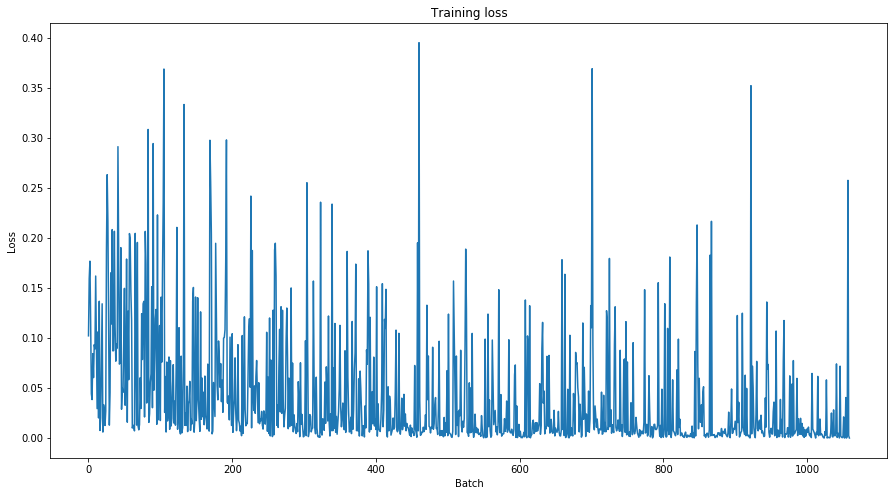

In [56]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()